Looking in indexes: https://download.pytorch.org/whl/cu124


In [1]:
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
import seaborn as sns
import numpy as np
import torchvision
import random
import torch
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
img_size = (256,256)
transformations = v2.Compose([
    #v2.ToImage(),
    v2.Resize(img_size),
    v2.RandomApply([
        v2.RandomRotation(degrees=(0, 20)),
        v2.RandomHorizontalFlip(p=1),
        v2.RandomPerspective(distortion_scale=0.2, p=0.5),
        v2.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.3, 0.3)),
    ], p=0.7),
    v2.RandomApply([
       v2.RandomAffine(degrees=0, scale=(0.6, 1.0)),
   ], p=0.5),
    v2.RGB(),
    #v2.ToDtype(torch.float32, scale=True),
    v2.ToTensor(),
])

dataset = datasets.ImageFolder('./Dataset-3', transform=transformations)

train, test = random_split(dataset, [0.8, 0.2])

trainloader = DataLoader(train, batch_size=32, shuffle=True)
testloader = DataLoader(test, batch_size=32, shuffle=False)

c:\Users\arthu\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


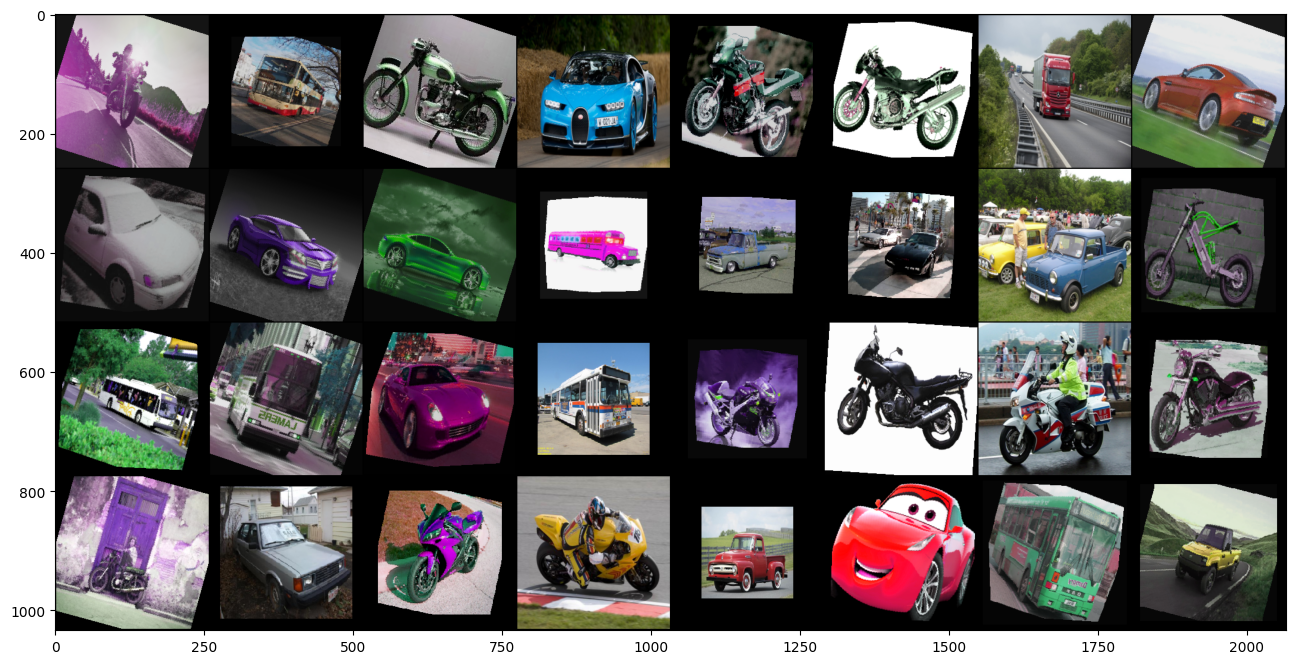

In [4]:
def imshow(img):
    plt.figure(figsize=(20,8))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images = next(dataiter)
imshow(torchvision.utils.make_grid(images[0]))

In [5]:
def validation(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(loader)

def train(model, trainloader, testloader, optimizer, criterion, epochs):
    best_val_loss = float('inf')  # Initialize the best validation loss as infinity
    patience_counter = 0  # Counter for early stopping
    patience = 5

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(trainloader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        val_loss = validation(model, testloader, criterion)
        print(f'Epoch: {epoch + 1} | Training Loss: {running_loss / len(trainloader):.4f} | Validation Loss: {val_loss:.4f}')

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset the counter when validation loss improves
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Early stopping patience: {patience_counter}/{patience}")
        
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
            

In [6]:
resnet = torchvision.models.resnet152(weights = torchvision.models.ResNet152_Weights.IMAGENET1K_V2)
resnet.fc = nn.Linear(2048, 4)

for name, params in resnet.named_parameters():
    if name not in ('fc.weight', 'fc.bias'):
        params.requires_grad = False

In [7]:
resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
epochs = 12

In [8]:
train(resnet, trainloader, testloader, optimizer, criterion, epochs)

#resnet.load_state_dict(torch.load("./model-9875-accuracy.pth", weights_only=True))

  0%|          | 0/14 [00:00<?, ?it/s]

 64%|██████▍   | 9/14 [00:58<00:22,  4.43s/it]c:\Users\arthu\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 14/14 [01:17<00:00,  5.56s/it]


Epoch: 1 | Training Loss: 1.1862 | Validation Loss: 0.9311


100%|██████████| 14/14 [00:50<00:00,  3.64s/it]


Epoch: 2 | Training Loss: 0.8560 | Validation Loss: 0.6745


100%|██████████| 14/14 [00:56<00:00,  4.02s/it]


Epoch: 3 | Training Loss: 0.6896 | Validation Loss: 0.5546


100%|██████████| 14/14 [01:00<00:00,  4.31s/it]


Epoch: 4 | Training Loss: 0.6103 | Validation Loss: 0.4716


100%|██████████| 14/14 [00:56<00:00,  4.05s/it]


Epoch: 5 | Training Loss: 0.5075 | Validation Loss: 0.4032


100%|██████████| 14/14 [00:54<00:00,  3.90s/it]


Epoch: 6 | Training Loss: 0.4725 | Validation Loss: 0.3849


100%|██████████| 14/14 [00:49<00:00,  3.57s/it]


Epoch: 7 | Training Loss: 0.4029 | Validation Loss: 0.3823


100%|██████████| 14/14 [00:57<00:00,  4.10s/it]


Epoch: 8 | Training Loss: 0.3835 | Validation Loss: 0.3691


100%|██████████| 14/14 [01:31<00:00,  6.50s/it]


Epoch: 9 | Training Loss: 0.3803 | Validation Loss: 0.3777
Validation loss did not improve. Early stopping patience: 1/5


100%|██████████| 14/14 [01:13<00:00,  5.28s/it]


Epoch: 10 | Training Loss: 0.3509 | Validation Loss: 0.2813


100%|██████████| 14/14 [01:16<00:00,  5.46s/it]


Epoch: 11 | Training Loss: 0.3287 | Validation Loss: 0.3274
Validation loss did not improve. Early stopping patience: 1/5


100%|██████████| 14/14 [01:20<00:00,  5.77s/it]


Epoch: 12 | Training Loss: 0.3127 | Validation Loss: 0.3310
Validation loss did not improve. Early stopping patience: 2/5


In [9]:
def accuracy(model, loader):
    model.eval()
    corrected = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            corrected += (predicted == labels).sum().item()
    return (corrected / total) * 100

def confusion_matrix(model, loader):
    model.eval()
    num_classes = 4
    confusion_matrix = torch.zeros(num_classes, num_classes)
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for true, pred in zip(labels, predicted):
                confusion_matrix[true.item(), pred.item()] += 1

    confusion_matrix = confusion_matrix.cpu().numpy()
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g',
                     xticklabels=['Bus', 'Car', 'Motorcycle', 'Truck'], yticklabels=['Bus', 'Car', 'Motorcycle', 'Truck'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.title("Confusion Matrix")
    plt.show()
    return ax

A rede atinge: 91.50943396226415% de acurácia


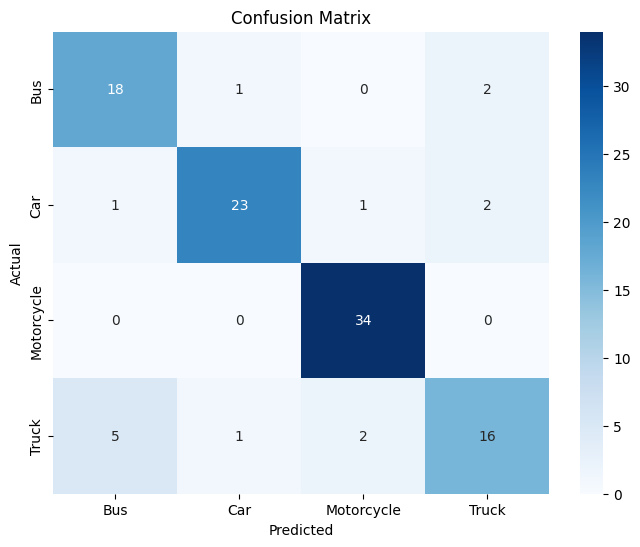

In [10]:
print(f'A rede atinge: {accuracy(resnet, testloader)}% de acurácia')
conf_mat = confusion_matrix(resnet, testloader)

In [12]:
def predict(model, image):
    prediction = model(torch.unsqueeze(image, 0).to(device))
    result = torch.argmax(prediction)
    return ['Bus', 'Car', 'Motorcycle', 'Truck'][result]

In [13]:
from PIL import Image
demo_imgs = "./Demo"
# Get all files in the folder
files = os.listdir(demo_imgs)

# Filter out image files (you can customize the extensions)
image_files = [file for file in files if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif'))]

for image in image_files:
    image_path = os.path.join(demo_imgs, image)  
    x = Image.open(image_path).convert('RGB')
    x = transformations(x)

    print(f'Resnet Prediction for {image}: {predict(resnet, x)}')

Resnet Prediction for bitrem.jpeg: Truck
Resnet Prediction for bus_poa.jpg: Bus
Resnet Prediction for corsamarelo.jpg: Car
Resnet Prediction for f1_1970.jpg: Car
Resnet Prediction for far_bike.jpg: Truck
Resnet Prediction for far_car.jpg: Car
Resnet Prediction for hd_electra.jpg: Motorcycle
Resnet Prediction for monstergolfcart.jpeg: Truck
Resnet Prediction for monstertruck.jpeg: Truck
Resnet Prediction for monza.jpg: Car
Resnet Prediction for motorhome.jpeg: Bus
Resnet Prediction for moto_velo.jpg: Motorcycle
Resnet Prediction for ram2500.jpg: Truck
Resnet Prediction for ram3500.jpg: Truck
Resnet Prediction for scania_truck.jpg: Truck
Resnet Prediction for tricycle_small.jpg: Truck


Comando para salvar o modelo para poder reutilizar futuramente

In [64]:
torch.save(resnet.state_dict(), './latest-model.pth')